In [11]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np

In [12]:
root_dir = '/tmp/PLD_3_Classes_256'

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/PLD_3_Classes_256/Training
/tmp/PLD_3_Classes_256/Testing
/tmp/PLD_3_Classes_256/Validation
/tmp/PLD_3_Classes_256/Training/Early_Blight
/tmp/PLD_3_Classes_256/Training/Late_Blight
/tmp/PLD_3_Classes_256/Training/Healthy
/tmp/PLD_3_Classes_256/Testing/Early_Blight
/tmp/PLD_3_Classes_256/Testing/Late_Blight
/tmp/PLD_3_Classes_256/Testing/Healthy
/tmp/PLD_3_Classes_256/Validation/Early_Blight
/tmp/PLD_3_Classes_256/Validation/Late_Blight
/tmp/PLD_3_Classes_256/Validation/Healthy


In [13]:
# let`s make EDA for the dataset
data_splits = os.listdir(root_dir)
for data_kind in data_splits:
    classes = os.listdir(os.path.join(root_dir,data_kind))
    print(f'*We Process the {data_kind}')
    for class_ in classes:
        path = os.path.join(os.path.join(root_dir,data_kind),class_)
        print(f'  we have a {len(os.listdir(path))} images from class {class_}')
    print('')

*We Process the Training
  we have a 1303 images from class Early_Blight
  we have a 1132 images from class Late_Blight
  we have a 816 images from class Healthy

*We Process the Testing
  we have a 162 images from class Early_Blight
  we have a 141 images from class Late_Blight
  we have a 102 images from class Healthy

*We Process the Validation
  we have a 163 images from class Early_Blight
  we have a 151 images from class Late_Blight
  we have a 102 images from class Healthy



In [14]:
# Filter out Corrupted images

num_skipped = 0
data_splits = os.listdir(root_dir)

for data_kind in data_splits:
    data_kind_path = os.path.join(root_dir,data_kind)
    print(f'*We Process the {data_kind}')
    
    classes = os.listdir(data_kind_path)
    for class_ in classes:
        folder_path = os.path.join(data_kind_path,class_)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path,fname)

            try:
                fobj = open(fpath,"rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                os.remove(fpath)
    print(f"  Deleted {num_skipped} Images for {data_kind}\n")

*We Process the Training
  Deleted 0 Images for Training

*We Process the Testing
  Deleted 0 Images for Testing

*We Process the Validation
  Deleted 0 Images for Validation



In [15]:
TRAINING_DIR = os.path.join(root_dir, "Training/")
VALIDATION_DIR = os.path.join(root_dir, "Validation/")
TEST_DIR = os.path.join(root_dir, "Testing/")

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 20

def train_val_test_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE
  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=IMAGE_SIZE,
                                                      color_mode='rgb', 
                                                      shuffle=True)

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1.0/255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=BATCH_SIZE,
                                                                class_mode='categorical',
                                                                target_size=IMAGE_SIZE,
                                                                color_mode='rgb', 
                                                                shuffle=True)

  test_datagen = ImageDataGenerator(rescale=1.0/255.)
  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=IMAGE_SIZE,
                                                    color_mode='rgb', 
                                                    shuffle=True)
  ### END CODE HERE
  return train_generator, validation_generator, test_generator

In [16]:
# Test your generators
train_generator, validation_generator, test_generator = train_val_test_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

Found 3251 images belonging to 3 classes.
Found 416 images belonging to 3 classes.
Found 405 images belonging to 3 classes.


In [17]:
# Looking the labels or classes of the dataset
# train_generator.class_indices to extract the classes(labels) of dataset that already augmented with ImageDataGenerator
# The labels in dictionary, the actual shape is {'Early_Blight': 0, 'Healthy': 1, 'Late_Blight': 2}

# We want to take the key of dictionary, and put that into list
class_names = list(train_generator.class_indices.keys())
print(class_names)

['Early_Blight', 'Healthy', 'Late_Blight']


In [18]:
# Get a batch of images and labels from the generator
images, labels = next(train_generator) 
# Here, next(train_generator) gets a batch of images and labels from the generator
print(labels[0]) # the labels already one hot encoded

[0. 0. 1.]


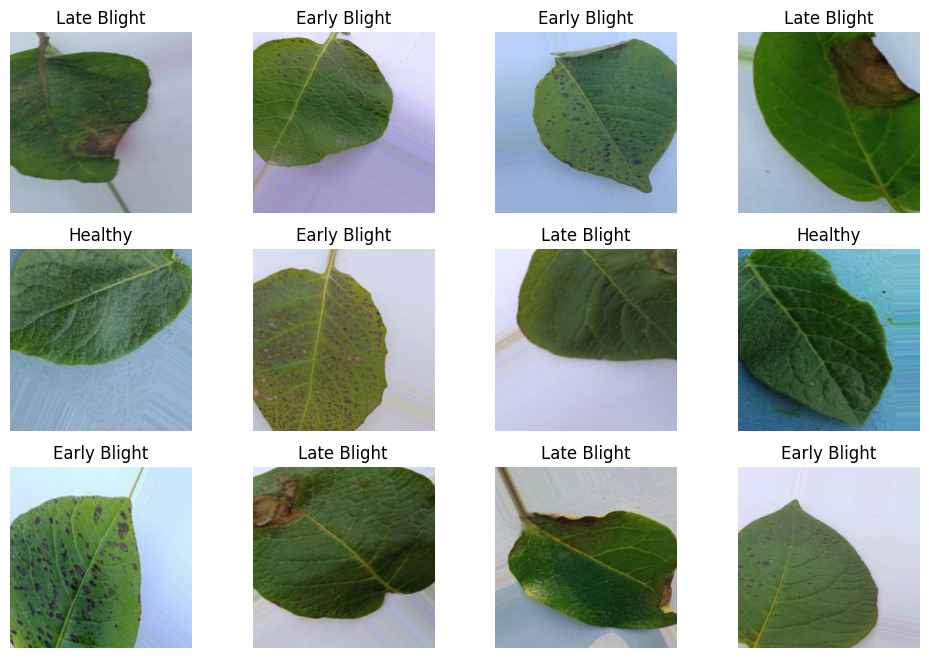

'\nnp.argmax(labels[i]) gets the index of the maximum value in the one-hot encoded label for the i-th image in the \nbatch. This index corresponds to the class label of the image. \n'

In [19]:
# Plot the images and set the title as the label of the first image in the batch
fig = plt.figure(figsize=(12, 8))
for i in range(0, 12):
    plt.subplot(3, 4, i+1)#creates a grid of 3 rows and 4 columns of subplots, and sets the current subplot to the i+1th subplot in the grid.
    plt.imshow(images[i])
    Class = ''
    if np.argmax(labels[i]) == 0:
        Class = 'Early Blight'
    elif np.argmax(labels[i]) == 1:
        Class = 'Healthy'
    else:
        Class = 'Late Blight'
    plt.title(Class)
    plt.axis('off')
    
plt.show()
'''
np.argmax(labels[i]) gets the index of the maximum value in the one-hot encoded label for the i-th image in the 
batch. This index corresponds to the class label of the image. 
'''

In [21]:
NUM_CLASSES = 3
INPUT_SHAPE = IMAGE_SIZE +(3,)

def create_model():
  

  ### START CODE HERE

  model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = INPUT_SHAPE),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Flatten Block
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  
  model.compile(optimizer='adam',
                loss='categorical_crossentropy', #kalau labelnya bukan one hot encoding pakenya sparse_categorical
                metrics=['accuracy']) 
    
  ### END CODE HERE

  return model

In [22]:
# Define Callback
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy')>=0.98):   
            keys = list(logs.keys())
            print("End epoch {} of training; got log keys: {}".format(epoch, keys))
            self.model.stop_training = True
            
# define object from CustomCallback Class
callbacks = CustomCallback()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

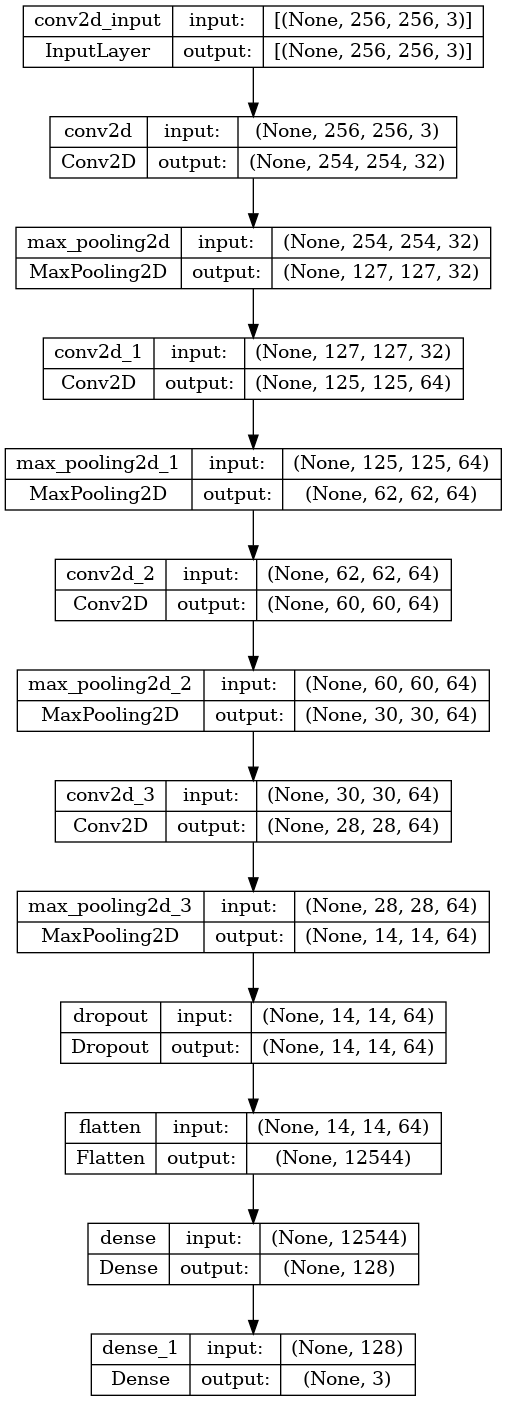

In [23]:
# training the model
model = create_model()
model.summary()

# plot the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
# training the model
model = create_model()

EPOCHS = 50
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    batch_size = BATCH_SIZE,
                    epochs =EPOCHS,
                    callbacks=[callbacks])

Epoch 1/50


2023-04-20 21:35:54.280130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-20 21:36:02.042891: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 165160960 exceeds 10% of free system memory.
2023-04-20 21:36:10.783220: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 165160960 exceeds 10% of free system memory.



  1/163 [..............................] - ETA: 54:23 - loss: 1.0836 - accuracy: 0.3500

2023-04-20 21:36:14.589965: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 165160960 exceeds 10% of free system memory.
2023-04-20 21:36:23.659327: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 165160960 exceeds 10% of free system memory.



  2/163 [..............................] - ETA: 33:45 - loss: 1.2171 - accuracy: 0.2500

2023-04-20 21:36:27.180990: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 165160960 exceeds 10% of free system memory.


163/163 [==============================] - ETA: 0s - loss: 1.0376 - accuracy: 0.4402 

2023-04-20 22:07:27.642430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


163/163 [==============================] - 1962s 12s/step - loss: 1.0376 - accuracy: 0.4402 - val_loss: 0.8872 - val_accuracy: 0.6130
Epoch 2/50
163/163 [==============================] - 1854s 11s/step - loss: 0.8841 - accuracy: 0.6097 - val_loss: 0.8002 - val_accuracy: 0.6538
Epoch 3/50
163/163 [==============================] - 1838s 11s/step - loss: 0.7765 - accuracy: 0.6801 - val_loss: 0.6154 - val_accuracy: 0.7356
Epoch 4/50
163/163 [==============================] - 1858s 11s/step - loss: 0.5986 - accuracy: 0.7733 - val_loss: 0.4491 - val_accuracy: 0.8269
Epoch 5/50
163/163 [==============================] - 1806s 11s/step - loss: 0.5767 - accuracy: 0.7841 - val_loss: 0.5531 - val_accuracy: 0.7668
Epoch 6/50
163/163 [==============================] - 1857s 11s/step - loss: 0.4870 - accuracy: 0.8247 - val_loss: 0.5851 - val_accuracy: 0.7620
Epoch 7/50
163/163 [==============================] - 1932s 12s/step - loss: 0.3762 - accuracy: 0.8674 - val_loss: 0.3051 - val_accuracy: 0.8

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])



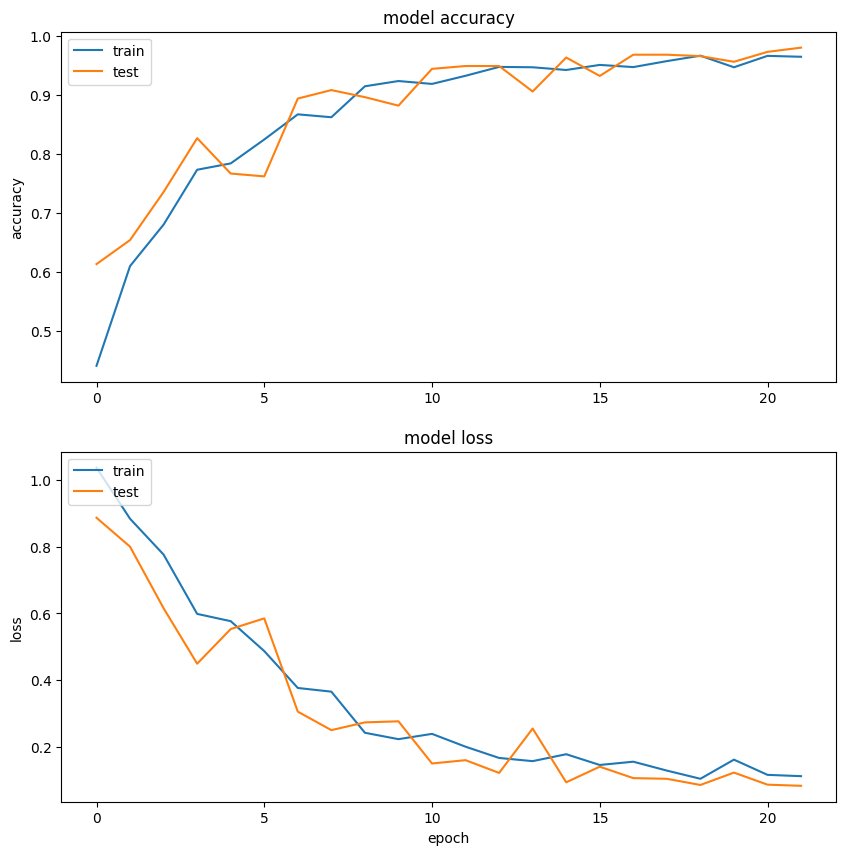

In [25]:
# list all data in history
print(history.history.keys())
print("")
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# evalute model
model.evaluate(test_generator)

2023-04-21 10:06:16.443275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


21/21 [==============================] - 35s 2s/step - loss: 0.0889 - accuracy: 0.9704


[0.08894717693328857, 0.970370352268219]

In [29]:
def download_history():
  import pickle
  with open('pld_model.pkl', 'wb') as f:
    pickle.dump(history.history, f)

download_history()

In [33]:
model.save('pld_model.h5')

1/1 [==============================] - 0s 228ms/step


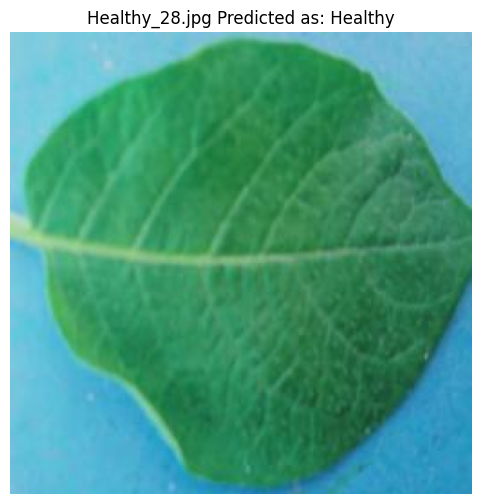

1/1 [==============================] - 0s 361ms/step


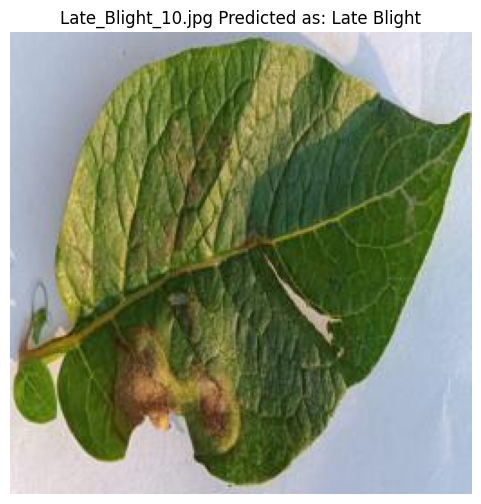

1/1 [==============================] - 0s 231ms/step


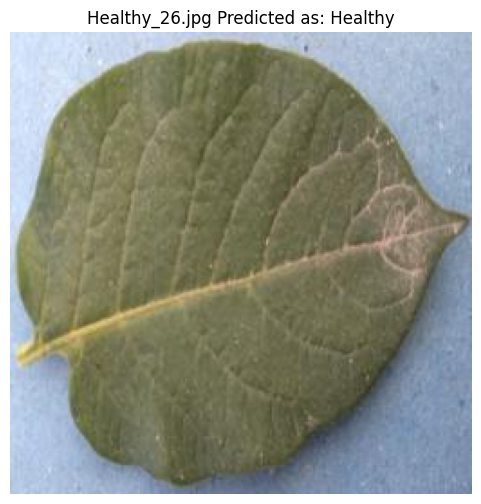

1/1 [==============================] - 0s 201ms/step


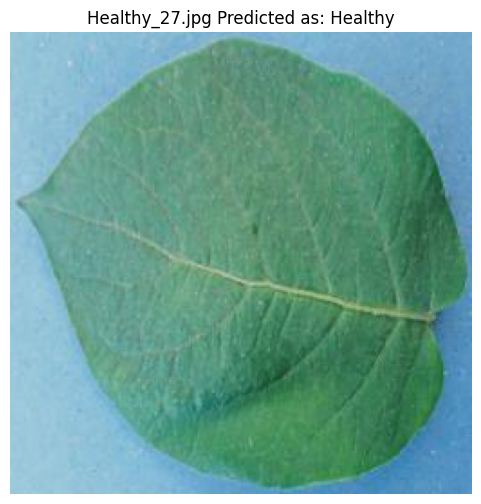

1/1 [==============================] - 0s 279ms/step


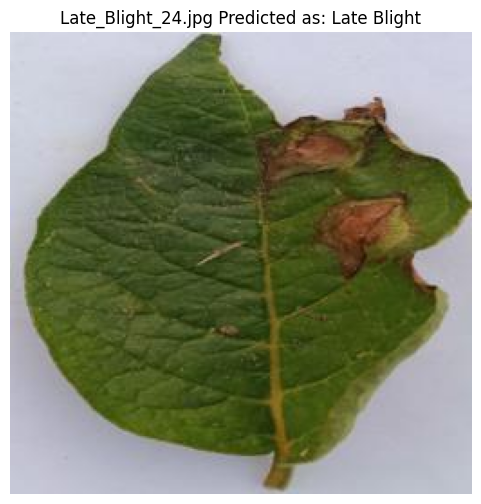

1/1 [==============================] - 0s 441ms/step


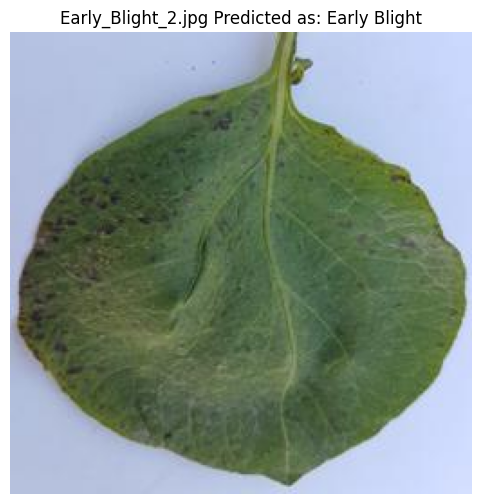

1/1 [==============================] - 0s 193ms/step


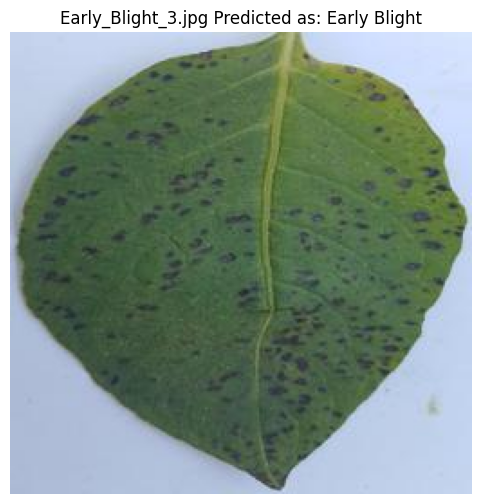

1/1 [==============================] - 0s 340ms/step


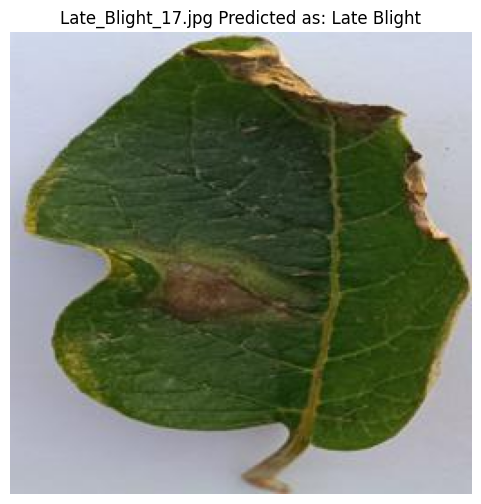

1/1 [==============================] - 0s 364ms/step


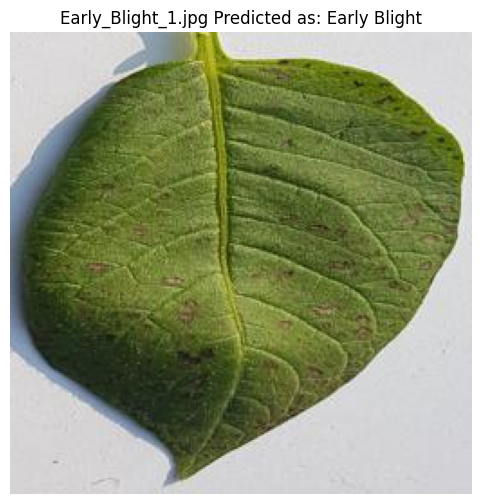

In [49]:
# load the model from the .h5 file
#model = load_model('pld_model.h5')

# set the path to the directory containing the images
image_dir = '/home/humaid/Potato_Leaf'

# loop through each file in the directory
for fn in os.listdir(image_dir):
    
    # check if the file is an image file (you can modify this condition based on your file naming convention)
    if fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.png'):
        
        # predicting images
        path = os.path.join(image_dir, fn)
        img = load_img(path, target_size=IMAGE_SIZE)
        
        x = img_to_array(img)
        x /= 255 # normalize the pixel values of the image to be between 0 and 1
        x = np.expand_dims(x, axis=0) # add an extra dimension to match the input shape of the model
        
        images = np.vstack([x]) # stack the single image array into a batch of images
        
        prediction = model.predict(images, batch_size=10)
        predicted_class = np.argmax(prediction)
        Class = ''
        if predicted_class == 0:
            Class = 'Early Blight'
        elif predicted_class == 1:
            Class = 'Healthy'
        else:
            Class = 'Late Blight'
         
        fig = plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(fn + " Predicted as: " + Class)
        plt.axis('off')
        plt.show()


In NumPy, the axis parameter indicates which axis of a multi-dimensional array should be modified. When we use np.expand_dims with axis=0, it adds an extra dimension to the beginning of the array.

In the context of the image classification code, the original x array is a 3D array with shape (IMAGE_SIZE, IMAGE_SIZE, 3). This means that it represents a single image with height and width of IMAGE_SIZE and 3 color channels (red, green, blue).

However, most deep learning models expect to receive a batch of images as input, where the first dimension of the input tensor is the batch size. By default, np.expand_dims adds a new axis at the end of the array, which is not what we want in this case. By specifying axis=0, we add a new dimension at the beginning of the array, which corresponds to the batch size. This results in a 4D array with shape (1, IMAGE_SIZE, IMAGE_SIZE, 3), where the first dimension represents the batch size (which is 1 in this case), and the remaining dimensions represent the image height, width, and color channels.

Adding this extra dimension is necessary to match the input shape expected by the pre-trained model, which was likely trained on batches of images rather than individual images. By expanding the dimensions of the input array in this way, we can ensure that the model will be able to process the input correctly.

In the context of the image classification code, np.vstack([x]) stacks a single numpy array x vertically into a new array, resulting in an array of size (1, IMAGE_SIZE, IMAGE_SIZE, 3). The new array has four dimensions:

The first dimension represents the batch size, which is 1 in this case, indicating that we are passing a single image to the model.
The second and third dimensions represent the height and width of the image, which are both IMAGE_SIZE in this case.
The fourth dimension represents the number of color channels in the image, which is 3 for RGB images.
By stacking the single image array vertically, we are essentially creating a "batch" of size 1 that the model can process. This is necessary because most deep learning models are designed to process batches of images rather than individual images. By feeding a batch of images to the model, we can take advantage of hardware optimization, such as processing multiple images in parallel on a GPU.

Note that np.vstack is a function that stacks a sequence of arrays vertically (along the first axis) to create a new array. In this case, we are only passing a single array to the function, but we still need to wrap it in a list ([x]) so that it is interpreted as a sequence of arrays.

here is an example of what happens before and after calling np.vstack:


Before calling np.vstack
x = np.array([[[0.1, 0.2, 0.3],
               [0.4, 0.5, 0.6],
               [0.7, 0.8, 0.9]]])
print(x.shape)  # (1, 3, 3)

After calling np.vstack
images = np.vstack([x])
print(images.shape)  # (1, 3, 3, 3)


In this example, x is a numpy array with shape (1, 3, 3), representing a single image with dimensions 3x3 and 1 color channel. After calling np.vstack([x]), we get a new numpy array images with shape (1, 3, 3, 3), representing a batch of 1 image with dimensions 3x3 and 3 color channels. The new array has an additional dimension at the end, which corresponds to the number of color channels in the image.

In [ ]:
from PIL import Image, ImageEnhance
from tensorflow.keras.models import load_model # untuk menggunakan fungsi load_model()
from tensorflow.keras.preprocessing.image import load_img, img_to_array # untuk menggunakan fungsi load_img()

# load the model from the .h5 file
model = load_model('pld_model.h5')

# set the path to the directory containing the images
image_dir = '/home/humaid/PL_Dieng'

# loop through each file in the directory
for fn in os.listdir(image_dir):
    
    # check if the file is an image file (you can modify this condition based on your file naming convention)
    if fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.png'):
        
        # predicting images
        path = os.path.join(image_dir, fn)
        img = Image.open(path)
        img = img.resize((256,256))
        # Create a contrast enhancer and reduce the contrast
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(0.5)  # 0.5 reduces the contrast by 50%
        #img.save('path/to/processed/image.jpg')
        
        img = img.convert('RGB') # convert the image to RGB mode
        x = img_to_array(img)
        x /= 255 # normalize the pixel values of the image to be between 0 and 1
        x = np.expand_dims(x, axis=0) # add an extra dimension to match the input shape of the model
        
        images = np.vstack([x]) # stack the single image array into a batch of images
        
        prediction = model.predict(images, batch_size=10)
        predicted_class = np.argmax(prediction)
        Class = ''
        if predicted_class == 0:
            Class = 'Early Blight'
        elif predicted_class == 1:
            Class = 'Healthy'
        else:
            Class = 'Late Blight'
         
        fig = plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(fn + " Predicted as: " + Class)
        plt.axis('off')
        plt.show()